In [27]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  

def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # # Make sure that the difference between the current and previous temperature cannot be too large.
    # # Define your threshold
    # threshold = 10
    # # Shift the 'temperature' column by one row to get the previous temperature
    # prev_tmp = df['temperature'].shift(1)
    # # Calculate the absolute difference between current and previous temperature
    # temp_diff = np.abs(df['temperature'] - prev_tmp)
    # # Set the temperature to NaN where the difference is larger than the threshold
    # df.loc[temp_diff > threshold, 'temperature'] = np.nan
    # df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()

def cal_diff(df: pd.DataFrame, n_int: int = 20):
    ''' # Description
    Calculate the difference between the current and previous n data point.
    '''
    # Tranform the features relative to the first data point.
    # df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
    # df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
    # df['position'] = df['position'] - df['position'].iloc[0]

    # Calculate the difference between the current and previous n data point.
    df['temperature_diff'] = df['temperature'].diff(n_int)
    df['voltage_diff'] = df['voltage'].diff(n_int)
    df['position_diff'] = df['position'].diff(n_int)    

def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    # Start processing.
    customized_outlier_removal(df)
    cal_diff(df)


In [28]:
import sys
import os
import matplotlib.pyplot as plt
from util import read_all_test_data_from_path
base_dictionary_train = "dataset/training_data/training_data/"
base_dictionary_test = "dataset/testing_data/"

df_train = read_all_test_data_from_path(base_dictionary_train, pre_processing=pre_processing, is_plot=False)
df_test = read_all_test_data_from_path(base_dictionary_test, pre_processing=pre_processing, is_plot=False)


In [29]:
#Train files
not_moving_train = ['20240105_164214', '20240105_165972', '20240320_152031', '20240320_155664','20240325_135213', '20240425_093699', '20240425_094425', '20240426_140055']
pickup_and_place_train = ['20240105_165300', '20240321_122650', '20240325_152902','20240325_155003', '20240426_141190','20240503_163963']
moving_one_motor_train = ['20240426_141532','20240426_141602','20240426_141726','20240426_141938','20240426_141980']
turning_motor_6_train = ['20240503_164435','20240503_164675','20240503_165189' ]
moving_motors_sequentially_train = ['20240320_153841']

moving_motor_mixed_train = moving_one_motor_train + moving_motors_sequentially_train + turning_motor_6_train
#Test files
transfer_goods_test = ["20240527_094865","20240527_100759","20240527_101627"]
not_moving_test = ['20240527_102436','20240527_102919','20240527_103311']
moving_one_motor_test = ['20240527_103690','20240527_104247']


In [30]:
# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced'))    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)


In [31]:
from utility import run_cv_one_motor
import warnings

warnings.filterwarnings('ignore')
# Specify the test conditions you would like to include in the test.
df_data_experiment = df_train[df_train['test_condition'].isin(moving_motor_mixed_train)]
# We want a five-fold cross validation.
n_cv = len(moving_motor_mixed_train)
# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

feature_list = ['data_motor_1_position', 'data_motor_1_temperature', 
                'data_motor_2_position', 'data_motor_2_temperature', 
                'data_motor_3_position', 'data_motor_3_temperature',
                'data_motor_4_position', 'data_motor_4_temperature']

all_result = run_cv_one_motor(single_run_result=False, motor_idx=6, df_data=df_data_experiment, mdl=grid_search, feature_list=feature_list, n_fold=n_cv)


Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.478750   0.000000  0.000000  0.000000
1  1.000000   1.000000  1.000000  1.000000
2  1.000000   1.000000  1.000000  1.000000
3  1.000000   1.000000  1.000000  1.000000
4  1.000000   1.000000  1.000000  1.000000
5  1.000000   1.000000  1.000000  1.000000
6  0.000000   0.000000  0.000000  0.000000
7  0.534224   0.750623  0.627083  0.683314
8  0.272844   0.272844  1.000000  0.428716


Mean performance metric and standard error:
Accuracy: 0.6984 +- 0.3871
Precision: 0.6693 +- 0.4481
Recall: 0.7363 +- 0.4349
F1 score: 0.6791 +- 0.4330




In [32]:
for i in range(1,7):
    print(df_train[f'data_motor_{i}_label'].value_counts())

data_motor_1_label
0    37960
1     1349
Name: count, dtype: int64
data_motor_2_label
0    32577
1     6732
Name: count, dtype: int64
data_motor_3_label
0    39182
1      127
Name: count, dtype: int64
data_motor_4_label
0    32570
1     6739
Name: count, dtype: int64
data_motor_5_label
0    39125
1      184
Name: count, dtype: int64
data_motor_6_label
0    37377
1     1932
Name: count, dtype: int64


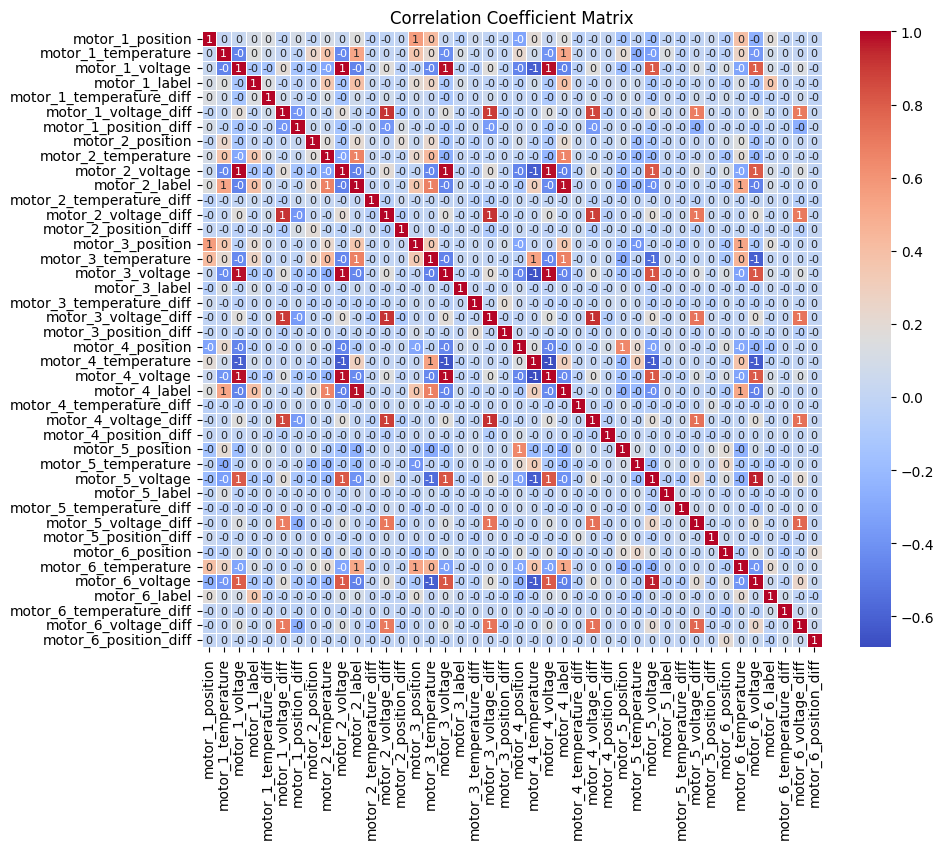

In [33]:
import seaborn as sns

col_to_plot = [col for col in df_train.columns if ('time' not in col and 'test' not in col)]

df_matrix = df_train.loc[:, col_to_plot]

correlation_matrix = df_matrix.corr()

correlation_matrix.columns = [col[5:] for col in correlation_matrix.columns]
correlation_matrix.index = [index[5:] for index in correlation_matrix.index]

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".0f", linewidths=0.5, annot_kws={"size": 8})

plt.title('Correlation Coefficient Matrix')
plt.show()